# This notebook is for visualizing and augmenting the German street sign data that was supplied with assignment.  
It is a good idea to understand the data before building a network.  This notebook reads the data and provides summary statistics about the different classes (comprised of 43 different sign classes).  Images are viewed. 

After understanding the data, data augmentation was used to increase the training, validation data.  That code is developed and exported to a python library for use in building and testing the model/

## Step 1: Load The Data

In [23]:
# Load pickled data
from matplotlib import pyplot as plt
import numpy as np
import pickle

import tensorflow as tf

#matplotlib

#dont forget to run: source activate carnd-term1  if tensorflow doesn't exist

epochs = 10
batch_size = 128
# TODO: Fill this in based on where you saved the training and testing data

test_valid_size = 256

training_file = './train.p'
validation_file= './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("class labels: ", np.unique(y_train))
#print(y_train[triangle_indices])
#y_train[triangle_indices] = 1

class labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [ ]:
## Use the cell below to see three copies of each class

class label:  0


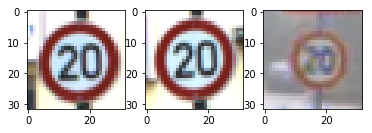

class label:  1


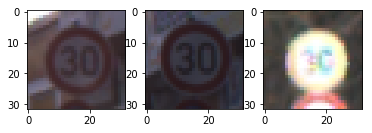

class label:  2


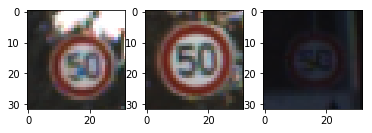

class label:  3


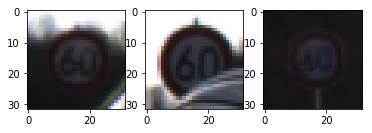

class label:  4


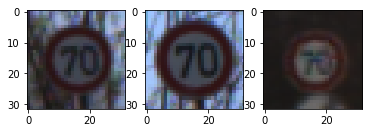

class label:  5


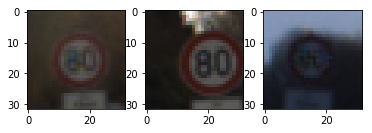

class label:  6


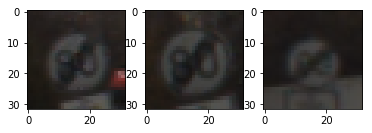

class label:  7


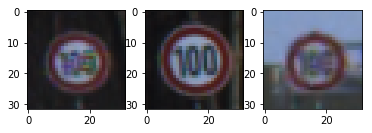

class label:  8


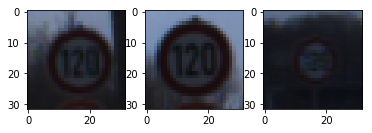

class label:  9


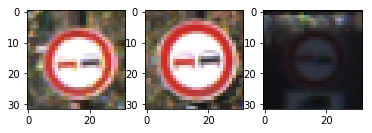

class label:  10


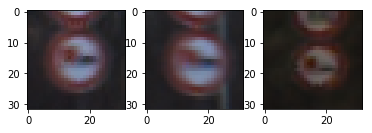

class label:  11


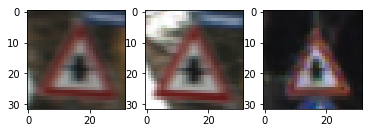

class label:  12


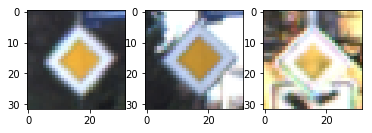

class label:  13


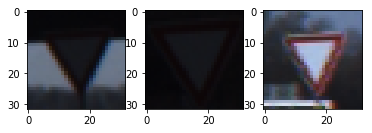

class label:  14


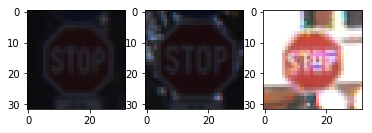

class label:  15


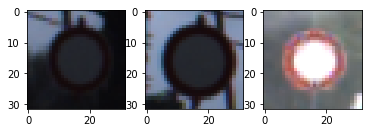

class label:  16


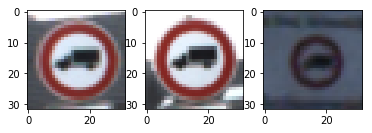

class label:  17


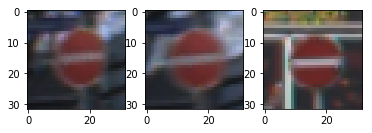

class label:  18


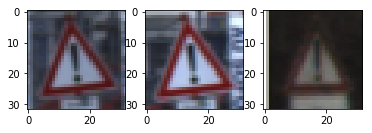

class label:  19


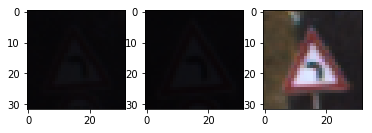

class label:  20


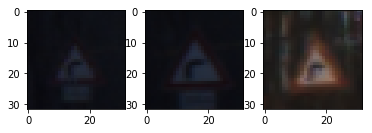

class label:  21


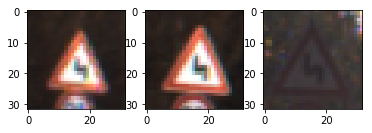

class label:  22


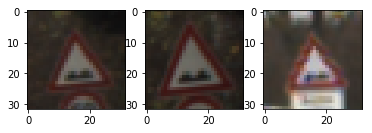

class label:  23


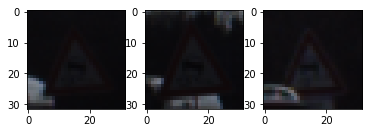

class label:  24


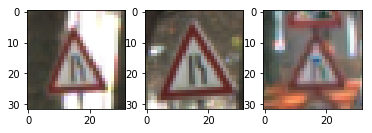

class label:  25


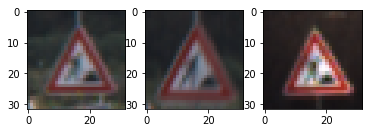

class label:  26


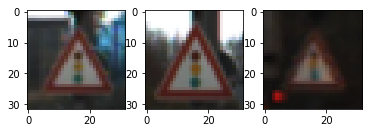

class label:  27


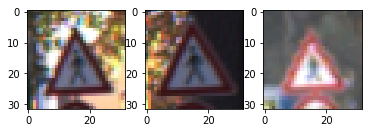

class label:  28


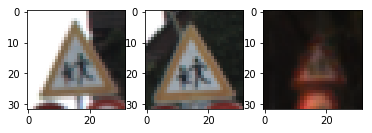

class label:  29


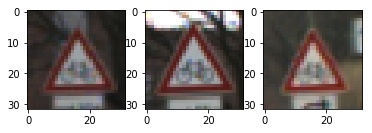

class label:  30


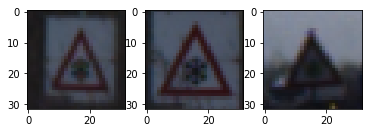

class label:  31


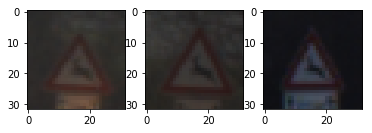

class label:  32


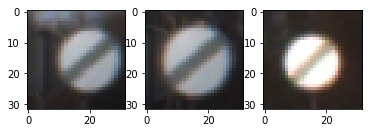

class label:  33


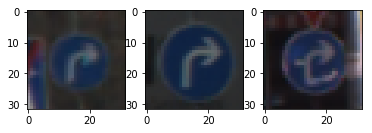

class label:  34


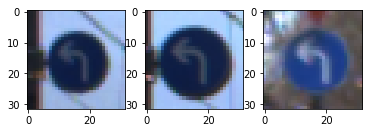

class label:  35


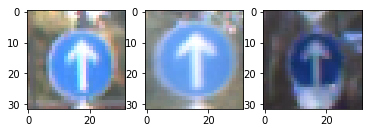

class label:  36


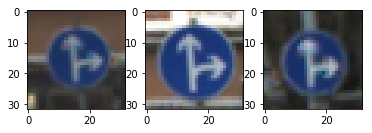

class label:  37


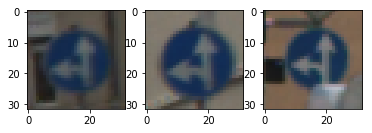

class label:  38


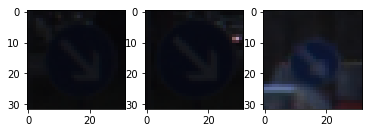

class label:  39


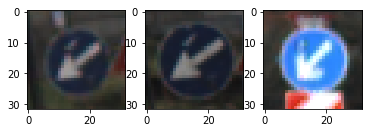

class label:  40


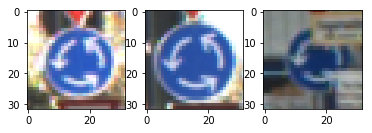

class label:  41


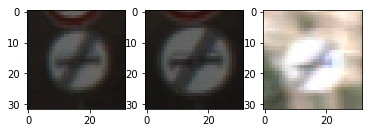

class label:  42


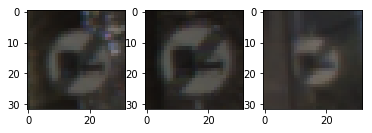

In [7]:
import numpy as np
import random
#show three examples from each class
for label in np.unique(y_train):
  class_indices = np.where(y_train==label)[0]
  print("class label: ", label)
    
  #show three randomly selected exemplars in a row
  for i in range(1,4):
    plt.subplot(1,3,i)
    exemplar = random.randint(0,len(class_indices)-1)
    plt.imshow(X_train[class_indices[exemplar],:,:,:])
    
  plt.show()

## Summary statistics for data

In [24]:

# Number of training examples in sets
n_train = len(y_train)
n_validation = len(y_validation)
n_test = len(y_test)


# an image is 3d, 32,32,3 (height, width, color channel)
image_shape = np.shape(X_train)[1:3]
print("Image data shape =", image_shape)

#number of classes = # of unique street signs
n_classes = len(np.unique(y_train))
print("Number of classes: ", n_classes)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)



Image data shape = (32, 32)
Number of classes:  43
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630


### Visualize the distribution of data among classes

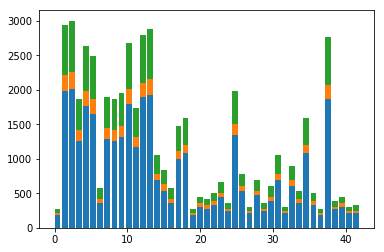

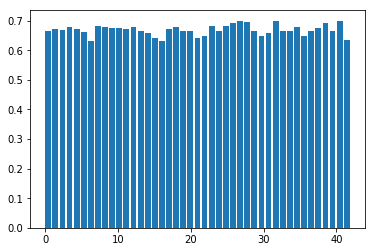

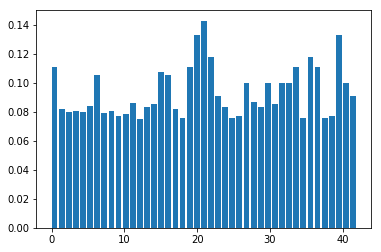

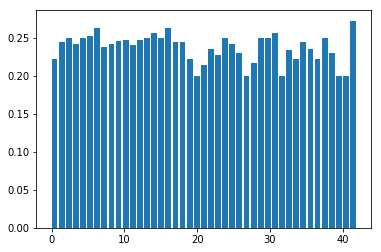

train dataset split percentage=  0.669176242744
validation dataset split percentage=  0.093458933132
test dataset split percentage=  0.237364824124


In [31]:
import matplotlib.pyplot as plt

#count the sign samples
train_hist, bin_edges = np.histogram(y_train,n_classes)
validation_hist, _ = np.histogram(y_validation,n_classes)
test_hist, _ = np.histogram(y_test, n_classes)

#make a figure of class distribution for saving 
#(saving only needed for the writeup)

fig, ax = plt.subplots()
plt.bar(bin_edges[:-1], train_hist)
plt.bar(bin_edges[:-1], validation_hist, bottom=train_hist)
plt.bar(bin_edges[:-1], test_hist, bottom=train_hist+validation_hist)
fig.savefig('./class_dist.png')  #save it
plt.show()

#are classes present in the same proportions in 
#train, validation and test? Yes.  See below
##compute the train test split per category

total_images_by_class = train_hist+validation_hist+test_hist
percent_train_by_class = train_hist/total_images_by_class
plt.bar(bin_edges[:-1],percent_train_by_class)
plt.show()

percent_validation_by_class = validation_hist/total_images_by_class
plt.bar(bin_edges[:-1],percent_validation_by_class)
plt.show()

percent_test_by_class = test_hist/total_images_by_class
plt.bar(bin_edges[:-1],percent_test_by_class)
plt.show()


#print train, validation and test percentages
print("train dataset split percentage= ",
    np.mean(percent_train_by_class))
print("validation dataset split percentage= ",
      np.mean(percent_validation_by_class))
print("test dataset split percentage= ",
      np.mean(percent_test_by_class))




## Data augmentation is necessary to generate enough training examples and, equally importantly, to have balanced data. 
The dataset is unbalanced and, therefore, underrepresented classes need to be boosted to the level of overrepresented classes.  Moreover, the overrepresented classes are not sufficiently large.
In order to generate batches for train, validation, and test, an iterator was created.  Using this iterator, a batch can be requested "on demand".  The batch is a mix of the original data provided in the pickle file plus synthetic examples sufficient to crate a balanced (i.e., each class is equally represented) batch of images.
Note: Due to time constraints, shrinking of the image was not used but would improvie performance of the synthetic image generation.

In [18]:
from skimage.transform import resize
import random
from skimage.transform import rotate
import cv2
from skimage.util import random_noise

def gen_data(image):
   imdim = np.shape(image)[0]
   ##generate random size; allow for 25% of image wideth
   newsize = random.randint(imdim,imdim+imdim//4)
   
   image_resized = resize(image, (newsize, newsize, 3),
                          mode='constant',cval=0, 
                          preserve_range=True, clip=True)
   #if newsize < imdim:
   #   image_background = np.random.random_sample((32,32,3))
       
   center = (imdim//2, imdim//2)
   M = cv2.getRotationMatrix2D(center, random.randint(-12,12), 1.0) 
   rotated = cv2.warpAffine(image_resized, M, (imdim, imdim))
   ##edgesize tells us max offset for translation
   edgesize = (newsize-imdim)//2
   
        
   offset = random.randint(-edgesize,edgesize) if edgesize>0 else 0 
   center = newsize//2 + offset
   #print(center, offset)
   sigma = random.uniform(0,.005)
   noisy = random_noise(image_resized, var=sigma*2)  
   outimage = noisy[center-16:center+16, center-16:center+16,:]
   return outimage
   #return outimage



In [19]:
import random
import numpy as np
import cv2
from sklearn.preprocessing import minmax_scale, scale

#labels = np.unique(y_train)
#print(labels)
#batch_size = 256
hist_train, _ = np.histogram(y_train,n_classes)   
hist_valid, _ = np.histogram(y_validation,n_classes)   
hist_test, _ = np.histogram(y_test,n_classes)   

def gen_batch(batch_type):
    
    if batch_type == 'train':
        hist = hist_train
        X_data = X_train
        y_data = y_train
    if batch_type == 'valid':
        hist = hist_valid
        X_data = X_validation
        y_data = y_validation
    if batch_type == 'test':
        hist = hist_test
        X_data = X_test
        y_data = y_test
        
        

    n_samples = 100000
    #n_labels = 100
    
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

    while True:
      X = np.zeros([batch_size,32,32,3], dtype='float64')
      labels = [random.randint(0,n_classes-1) for i in range(batch_size)]
      #print(labels)
      for indx, label in enumerate(labels):
         ##find the number of exemplars for this label
         n_labels = hist[label]
         label_indices = np.where(y_data==label)[0]
        
         ##source_image will either be returned or used to 
         ##generate a synthetic image
         image_number = label_indices[random.randint(0,n_labels-1)]
       
         lab = cv2.cvtColor(X_data[image_number,:,:,:], cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
         l, a, b = cv2.split(lab)  # split on 3 different channels

         l2 = clahe.apply(l)  # apply CLAHE to the L-channel
 
         lab = cv2.merge((l2,a,b))  # merge channels
         source_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR).astype('float')          
         #source_image = X_data[image_number,:,:,:].astype('float')
  
         shape = source_image.shape
         ##ravel flattens the image
         source_image = minmax_scale(source_image.ravel(), 
                        feature_range=(0,1)).reshape(shape)

         ##decide whether to use the source image or generate a synthetic
         ##using randint.  The more source images you have the less likely
         ##you are to generate an image.  n_samples is the total number of
         ##samples/class desired.  
         #
         if random.randint(0,n_samples) > n_labels:
            X[indx,:,:,:] = gen_data(source_image)
         else:
            X[indx,:,:,:] = source_image
            
         y_one_hot = dense_to_one_hot(np.array(labels), n_classes)
        
      yield X, y_one_hot

In [ ]:
train_iterator = gen_batch('train')
valid_iterator = gen_batch('valid')
test_iterator = gen_batch('test')

## Grab a batch of training images and examine.
* The added noise added might look weird but will help for generalization later

In [21]:
batch_x, batch_y = next(train_iterator)

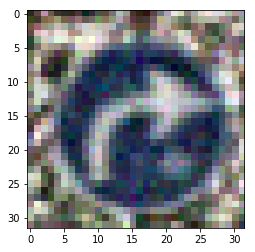

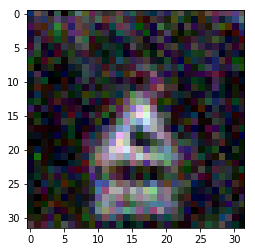

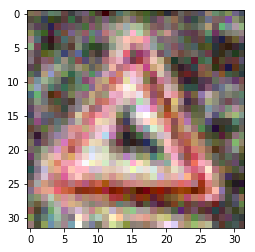

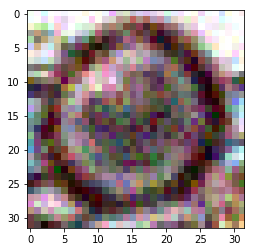

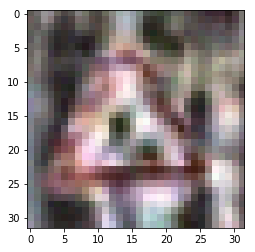

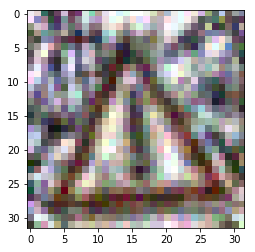

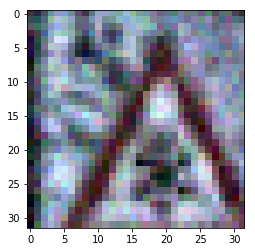

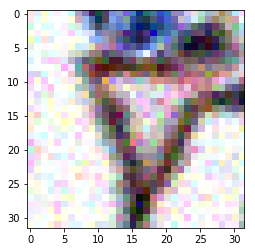

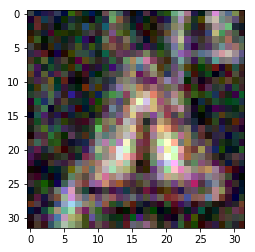

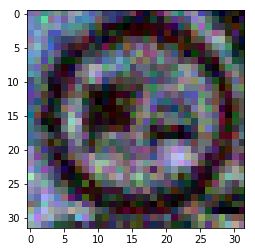

In [22]:
for i in range(10):
  #print(np.min(batch_x[i,:,:,:]))
  plt.imshow(batch_x[i,:,:,:])
  plt.show()